# Implementation

In [2]:
"""
This module defines the Board and Car classes for the rush-hour game
The Car class serve more to store car data and logic involving possible
moves of car in the board is defined in the Board class
"""
from copy import deepcopy
from collections import defaultdict
import pdb


class Orientation(object):
    """ Direction of the car"""
    HORIZONTAL = 0
    VERTICAL = 1


class Car(object):
    """Car Class for the Rushhour game
    Attributes:
        name: character
        coord: Coordinate of the car in the board
        length: length of the car (e.g space occupiying the board)
        orientation: horizontal or vertical alighment
        is_red_car: the car to be freed
    """

    def __init__(self, name, coord, length, orientation, is_red_car=None):
        self.name = name
        self.coord = coord
        self.length = length - 1 
        self.orientation = orientation
        self.is_red_car = is_red_car

    def __eq__(self, other):
        return self.__dict__ == other.__dict__

    def __str__(self):
        return str(self.__dict__)

    def __ne__(self, other):
        return not self.__eq__(other)

    def __hash__(self):
        return hash(self.__repr__())

    def __repr__(self):
        if self.orientation == Orientation.HORIZONTAL:
            other_coord = {'x': self.coord['x'] + self.length,
                           'y': self.coord['y']}
            return "{} [{},{}]".format(self.name, self.coord, other_coord)
        else:
            other_coord = {'x': self.coord[
                'x'], 'y': self.coord['y'] + self.length}
            return "{} [{},{}]".format(self.name, self.coord, other_coord)
    

    def move(self, direction, distance):
        """Given the direction and distance, move the car according to it
        """
        if direction == 'up':
            self.coord['y'] -= distance

        if direction == 'down':
            self.coord['y'] += distance

        if direction == 'left':
            self.coord['x'] -= distance

        if direction == 'right':
            self.coord['x'] += distance

    @staticmethod
    def createFromBoardInfo(name, coords):
        def plane(coords):
            if coords[0]['x'] != coords[1]['x'] and coords[0]['y'] == coords[1]['y']:
                return Orientation.HORIZONTAL
            else:
                return Orientation.VERTICAL
        return Car(name, coords[0], len(coords), plane(coords), is_red_car=(name == 'r'))


class Board(object):
    """Board Class for setting up the playing board
    Attributes:
        cars: list of cars on the play board
        size: size of the board
    """

    def __init__(self, cars, width=6, height=6):
        self.size = {'x': height, 'y': width}
        self.cars = cars
        self.depth = 0
        self.hval = 0

    def __eq__(self, other):
        return self.cars == other.other

    def __str__(self):
        return str(self.__dict__)

    def __ne__(self, other):
        return not self.__eq__(other)

    def __hash__(self):
        return hash(self.__repr__())

    @staticmethod
    def readFromfile(filename):
        """Reads a puzzle from a file and creates a new board instance, identifies the red car and board dimensions """
        def get_coord(row_idx):
            def result(tup):
                return (tup[1], {'y': row_idx, 'x': tup[0]})
            return result

        def flatten(l):
            return [item for sublist in l for item in sublist]

        puzzle_file = open(filename, 'r')
        raw_board = [list(line.strip()) for line in puzzle_file]
        coords_board = [map(get_coord(row_idx), enumerate(row))
                        for row_idx, row in enumerate(raw_board)]
        cars_board = flatten([filter(lambda t: t[0].isalpha(), list(row))
                              for row in list(coords_board)])
        raw_cars = defaultdict(list)
        for (k, v) in cars_board:
            raw_cars[k].append(v)
        cars = []
        for i in raw_cars:
            cars.append(Car.createFromBoardInfo(i, raw_cars[i]))
        return Board(cars, len(raw_board), len(raw_board[0]))

    def explore_moves(self):
        """Explore the state space of possible moves for a single car, this also checks whether we bump into a car or a wall"""
        board = self.game_board(self.cars)
        for car in self.cars:
            if car.orientation == Orientation.VERTICAL:
                # UP
                if car.coord['y'] - 1 >= 0 and board[car.coord['y'] - 1][car.coord['x']] == '.':
                    new_cars = deepcopy(self.cars)
                    new_car = [x for x in new_cars if x.name == car.name][0]
                    new_car.coord['y'] -= 1
                    yield [[[car.name, 'up']], Board(new_cars)]
                # DOWN
                if car.coord['y'] + car.length + 1 <= (self.size['x'] - 1) and board[car.coord['y'] + car.length + 1][car.coord['x']] == '.':
                    new_cars = deepcopy(self.cars)
                    new_car = [x for x in new_cars if x.name == car.name][0]
                    new_car.coord['y'] += 1
                    yield [[[car.name, 'down']], Board(new_cars)]
            else:
                # LEFT
                if car.coord['x'] - 1 >= 0 and board[car.coord['y']][car.coord['x'] - 1] == '.':
                    new_cars = deepcopy(self.cars)
                    new_car = [x for x in new_cars if x.name == car.name][0]
                    new_car.coord['x'] -= 1
                    yield [[[car.name, 'left']], Board(new_cars)]
                # RIGHT
                if car.coord['x'] + car.length + 1 <= (self.size['y'] - 1) and board[car.coord['y']][car.coord['x'] + car.length + 1] == '.':
                    new_cars = deepcopy(self.cars)
                    new_car = [x for x in new_cars if x.name == car.name][0]
                    new_car.coord['x'] += 1
                    yield [[[car.name, 'right']], Board(new_cars)]

    def game_board(self, cars):
        """Given a set of cars, create a 2D array of the puzzle"""
        board = [['.' for col in range(self.size['x'])]
                 for row in range(self.size['y'])]
        for car in cars:
            if car.orientation == Orientation.HORIZONTAL:
                x_start = car.coord['x']
                x_stop = car.coord['x'] + car.length
                for x in range(x_start, x_stop + 1):
                    board[car.coord['y']][x] = car.name
            else:
                y_start = car.coord['y']
                y_stop = car.coord['y'] + car.length
                for y in range(y_start, y_stop + 1):
                    board[y][car.coord['x']] = car.name
        return board

    def prettify(self, cars):
        """Printable version that represents the 2D array of the puzzle"""
        board = self.game_board(cars)
        output = ''
        for line in board:
            output += " ".join(line) + '\n'
        return output

    def is_solved(self):
        """Check if the red_car is free"""
        red_car = [car for car in self.cars if car.is_red_car][0]
        return red_car.coord['x'] + red_car.length == self.size['x'] - 1

In [16]:
import heapq
from copy import deepcopy


class PriorityQueue:
    """A simple version of a Priority Queue, that allows to give a priority value to an element"""

    def __init__(self):
        self._queue = []
        self._dictq = {}
        self._index = 0

    def push(self, item, priority):
        heapq.heappush(self._queue, (priority, self._index, item))
        self._dictq[hash(str(item[1]))] = priority
        self._index += 1

    def empty(self):
        return len(self._queue) == 0

    def pop(self):
        return heapq.heappop(self._queue)[-1]
    

class NotSolvable(Exception):
    pass

class ZeroHeuristic:
    """Zero Heuristcs, same as a BFS search"""

    def calculate(self, board):
        return 0

    def __repr__(self):
        return 'ZeroHeuristic'


class BlockingCarsHeuristic:
    """Calculate number of cars blocking the way plus distance"""

    def calculate(self, board):
        red_car = [
            car for car in board.cars if car.is_red_car][0]
        if red_car.coord['x'] == 4:
            return 0

        dist = 5 - (red_car.coord['x'] + 1)

        blockingcars = 0
        for car in board.cars:
            if (car.orientation == Orientation.VERTICAL 
                and car.coord['x'] >= (red_car.coord['x'] + red_car.length) 
                and (car.coord['y'] <= red_car.coord['y'] and car.coord['y'] + car.length >= red_car.coord['y'])
                ):
                blockingcars += 1

        return blockingcars + dist

    def __repr__(self):
        return 'BlockingCarsHeuristic'

class BlockingBlockingCarsHeuristic:
    """Calculate number of cars blocking the way plus distance plus cars blocking the blocking cars"""

    def calculate(self, board):
        red_car = [
            car for car in board.cars if car.is_red_car][0]
        if red_car.coord['x'] == 4:
            return 0

        dist = 5 - (red_car.coord['x'] + 1)

        blockingcars = 0
        blockingBlocking = 0
        for car in board.cars:
            if (car.orientation == Orientation.VERTICAL 
                and car.coord['x'] >= (red_car.coord['x'] + red_car.length) 
                and (car.coord['y'] <= red_car.coord['y'] and car.coord['y'] + car.length >= red_car.coord['y'])
                ):
                blockingcars += 1
                for car2 in board.cars:
                  if (car2.orientation == Orientation.VERTICAL 
                      and car2.coord['x'] == car.coord['x'] 
                      and (car2.coord['y'] + car2.length == car.coord['y'] - 1 or car2.coord['y'] == car.coord['y'] + car.length + 1)
                      ):
                    blockingBlocking += 1
                  if (car2.orientation == Orientation.HORIZONTAL 
                      and (car.coord['x'] >= car2.coord['x'] and car.coord['x'] <= car2.coord['x'] + car2.length) 
                      and (car2.coord['y'] == car.coord['y'] - 1 or car2.coord['y'] == car.coord['y'] + car.length + 1)
                      ):
                    blockingBlocking += 1

        return blockingcars + dist + blockingBlocking

    def __repr__(self):
        return 'BlockingBlockingCarsHeuristic'


class Solver(object):
    """The Solver class takes as input the board to be solved
        Attributes:
        board: the initial config of the puzzle
        hfn: heuristic_function
    """

    def __init__(self, board, hfn):
        self.board = board
        self.hfn = hfn
        self.visited = 0
        self.generated = 0
        self.path = []
        self.path_dict = {}
        self.dup = {}

    def solve(self):
        frontier = PriorityQueue()
        board = self.board
        closed_set = set()
        frontier.push([[], board], 0)
        g = {}
        g[hash(str(board))] = 0
        while not frontier.empty():
            moves, board = frontier.pop()
            frontier._dictq.pop(hash(str(board)))

            if board.is_solved():
                return (moves, len(closed_set), len(frontier._queue))
            
            closed_set.add(hash(str(board)))

            for new_moves, new_boards in board.explore_moves():
                new_g = g[hash(str(board))] + 1
                # f = g(u) + h(u)
                priority = new_g + self.hfn.calculate(new_boards)
                if hash(str(new_boards)) in frontier._dictq or new_boards in closed_set:
                    if new_g >= g[hash(str(new_boards))]:
                      continue
                    else:
                        closed_set.remove(hash(str(new_boards)))

                frontier.push([moves + new_moves, new_boards], priority)
                g[hash(str(new_boards))] = new_g

        raise NotSolvable('Not able to solve!')


    def solveIDA(self):
      threshold = self.hfn.calculate(self.board)
      self.path.append([[], self.board])
      self.path_dict[hash(str(self.board))] = threshold
      self.dup[hash(str(self.board))] = 0
      g = {}
      g[hash(str(self.board))] = 0

      def IDArec(curThreshold):
        moves, board = self.path[-1:][0]
        priority = g[hash(str(board))] + self.hfn.calculate(board)
        min = float("inf")

        if priority > curThreshold:
          return priority

        self.visited += 1
        self.dup[hash(str(board))] += 1

        if board.is_solved():
          return (moves, self.visited, self.generated, self.dup)

        for new_moves, new_boards in board.explore_moves():      
          if hash(str(new_boards)) not in self.path_dict:
            new_g = g[hash(str(board))] + 1
            g[hash(str(new_boards))] = new_g
            new_priority = new_g + self.hfn.calculate(new_boards)
            if hash(str(new_boards)) not in self.dup: self.dup[hash(str(new_boards))] = 0
            self.generated += 1
            self.path.append([moves + new_moves, new_boards])
            self.path_dict[hash(str(new_boards))] = new_priority
            t = IDArec(curThreshold)
            if isinstance(t, tuple):
              return t
            elif t < min:
                min = t
            del self.path[-1]
            self.path_dict.pop(hash(str(new_boards)))

        return min

      while True:
        t = IDArec(threshold)
        if isinstance(t, tuple):
          self.path = []
          self.path_dict = {}
          self.visited = 0
          self.generated = 0
          self.dup = {}
          return (t[0], t[1], t[2], t[3])
        if t == float("inf"):
          raise NotSolvable('Not able to solve!') 
        else:
          threshold = t


    def solution(self, board, moves):
        """Format the steps and provide a step-by-step guide to solve the puzzle"""
        output = ''
        output += "; ".join(["{} {}".format(move[0], move[1]) for move in moves])
        cars = deepcopy(board.cars)
        for move in moves:
            car = [x for x in cars if x.name == move[0]][0]
            output += '\nMOVE {} {}\n'.format(move[0], move[1])
            car.move(move[1], 1)
            output += self.board.prettify(cars)
        return output

    def solutionMoves(self, moves):
      output = ''
      output += "; ".join(["{} {}".format(move[0], move[1]) for move in moves])
      return output

# Tests

In [12]:
import time

b = Board.readFromfile('p1.txt')
print(b.prettify(b.cars))
astar1 = Solver(b, BlockingCarsHeuristic())
IDAstar1 = Solver(b, BlockingCarsHeuristic())
astar2 = Solver(b, BlockingBlockingCarsHeuristic())
IDAstar2 = Solver(b, BlockingBlockingCarsHeuristic())

start_astar1 = time.time()
moves_astar1, closed_astar1, open_astar1 = astar1.solve()
end_astar1 = time.time()

print(f"A* BCars - num of moves: {len(moves_astar1)}, num of nodes passes: {closed_astar1}, num of nodes gen: {open_astar1 + closed_astar1}, time: {end_astar1 - start_astar1}")
print(astar1.solutionMoves(moves_astar1))

start_astar2 = time.time()
moves_astar2, closed_astar2, open_astar2 = astar2.solve()
end_astar2 = time.time()

print(f"A* BBCars - num of moves: {len(moves_astar2)}, num of nodes passes: {closed_astar2}, num of nodes gen: {open_astar2 + closed_astar2}, time: {end_astar2 - start_astar2}")
print(astar2.solutionMoves(moves_astar2))

start_IDAstar1 = time.time()
moves_IDAstar1, visited_IDAstar1, generated_IDAstar1, dup_IDAstar1 = IDAstar1.solveIDA()
end_IDAstar1 = time.time()

dup_IDAstar1_num = 0
for key,val in dup_IDAstar1.items():
  if val > 1: dup_IDAstar1_num += (val - 1)

print(f"IDA* BCars - num of moves: {len(moves_IDAstar1)}, num of nodes passes: {visited_IDAstar1}, num of nodes gen: {generated_IDAstar1}, duplicates passes: {dup_IDAstar1_num}, time: {end_IDAstar1 - start_IDAstar1}")
print(IDAstar1.solutionMoves(moves_IDAstar1))

start_IDAstar2 = time.time()
moves_IDAstar2, visited_IDAstar2, generated_IDAstar2, dup_IDAstar2 = IDAstar2.solveIDA()
end_IDAstar2 = time.time()

dup_IDAstar2_num = 0
for key,val in dup_IDAstar2.items():
  if val > 1: dup_IDAstar2_num += (val - 1)

print(f"IDA* BBCars - num of moves: {len(moves_IDAstar2)}, num of nodes passes: {visited_IDAstar2}, num of nodes gen: {generated_IDAstar2}, duplicates passes: {dup_IDAstar2_num}, time: {end_IDAstar2 - start_IDAstar2}")
print(IDAstar2.solutionMoves(moves_IDAstar2))

. . A A . O
. . . . . O
. . . r r O
B . . . . .
B X X X . .
. . . . . .

A* BCars - num of moves: 4, num of nodes passes: 27, num of nodes gen: 102, time: 0.03453636169433594
O down; O down; O down; r right
A* BBCars - num of moves: 4, num of nodes passes: 27, num of nodes gen: 102, time: 0.035491943359375
O down; O down; O down; r right
IDA* BCars - num of moves: 4, num of nodes passes: 26, num of nodes gen: 143, duplicates passes: 7, time: 0.03542470932006836
O down; O down; O down; r right
IDA* BBCars - num of moves: 4, num of nodes passes: 26, num of nodes gen: 143, duplicates passes: 7, time: 0.050110578536987305
O down; O down; O down; r right


In [14]:
b = Board.readFromfile('p2.txt')
print(b.prettify(b.cars))
astar1 = Solver(b, BlockingCarsHeuristic())
IDAstar1 = Solver(b, BlockingCarsHeuristic())
astar2 = Solver(b, BlockingBlockingCarsHeuristic())
IDAstar2 = Solver(b, BlockingBlockingCarsHeuristic())

start_astar1 = time.time()
moves_astar1, closed_astar1, open_astar1 = astar1.solve()
end_astar1 = time.time()

print(f"A* BCars - num of moves: {len(moves_astar1)}, num of nodes passes: {closed_astar1}, num of nodes gen: {open_astar1 + closed_astar1}, time: {end_astar1 - start_astar1}")
print(astar1.solutionMoves(moves_astar1))

start_astar2 = time.time()
moves_astar2, closed_astar2, open_astar2 = astar2.solve()
end_astar2 = time.time()

print(f"A* BBCars - num of moves: {len(moves_astar2)}, num of nodes passes: {closed_astar2}, num of nodes gen: {open_astar2 + closed_astar2}, time: {end_astar2 - start_astar2}")
print(astar2.solutionMoves(moves_astar2))

start_IDAstar1 = time.time()
moves_IDAstar1, visited_IDAstar1, generated_IDAstar1, dup_IDAstar1 = IDAstar1.solveIDA()
end_IDAstar1 = time.time()

dup_IDAstar1_num = 0
for key,val in dup_IDAstar1.items():
  if val > 1: dup_IDAstar1_num += (val - 1)

print(f"IDA* BCars - num of moves: {len(moves_IDAstar1)}, num of nodes passes: {visited_IDAstar1}, num of nodes gen: {generated_IDAstar1}, duplicates passes: {dup_IDAstar1_num}, time: {end_IDAstar1 - start_IDAstar1}")
print(IDAstar1.solutionMoves(moves_IDAstar1))

start_IDAstar2 = time.time()
moves_IDAstar2, visited_IDAstar2, generated_IDAstar2, dup_IDAstar2 = IDAstar2.solveIDA()
end_IDAstar2 = time.time()

dup_IDAstar2_num = 0
for key,val in dup_IDAstar2.items():
  if val > 1: dup_IDAstar2_num += (val - 1)

print(f"IDA* BBCars - num of moves: {len(moves_IDAstar2)}, num of nodes passes: {visited_IDAstar2}, num of nodes gen: {generated_IDAstar2}, duplicates passes: {dup_IDAstar2_num}, time: {end_IDAstar2 - start_IDAstar2}")
print(IDAstar2.solutionMoves(moves_IDAstar2))

. . . . A A
. . . C C O
. r r . Q O
. . . . Q O
. . . . Q .
. . X X X .

A* BCars - num of moves: 7, num of nodes passes: 71, num of nodes gen: 281, time: 0.11063313484191895
r right; X left; Q down; r right; O down; O down; r right
A* BBCars - num of moves: 7, num of nodes passes: 18, num of nodes gen: 107, time: 0.028548479080200195
X left; Q down; O down; O down; r right; r right; r right
IDA* BCars - num of moves: 7, num of nodes passes: 126, num of nodes gen: 814, duplicates passes: 69, time: 0.23008060455322266
O down; O down; r right; X left; Q down; r right; r right
IDA* BBCars - num of moves: 8, num of nodes passes: 34, num of nodes gen: 250, duplicates passes: 14, time: 0.0709383487701416
A left; r right; X left; Q down; O down; O down; r right; r right


In [13]:
b = Board.readFromfile('p3.txt')
print(b.prettify(b.cars))
astar1 = Solver(b, BlockingCarsHeuristic())
IDAstar1 = Solver(b, BlockingCarsHeuristic())
astar2 = Solver(b, BlockingBlockingCarsHeuristic())
IDAstar2 = Solver(b, BlockingBlockingCarsHeuristic())

start_astar1 = time.time()
moves_astar1, closed_astar1, open_astar1 = astar1.solve()
end_astar1 = time.time()

print(f"A* BCars - num of moves: {len(moves_astar1)}, num of nodes passes: {closed_astar1}, num of nodes gen: {open_astar1 + closed_astar1}, time: {end_astar1 - start_astar1}")
print(astar1.solutionMoves(moves_astar1))

start_astar2 = time.time()
moves_astar2, closed_astar2, open_astar2 = astar2.solve()
end_astar2 = time.time()

print(f"A* BBCars - num of moves: {len(moves_astar2)}, num of nodes passes: {closed_astar2}, num of nodes gen: {open_astar2 + closed_astar2}, time: {end_astar2 - start_astar2}")
print(astar2.solutionMoves(moves_astar2))

start_IDAstar1 = time.time()
moves_IDAstar1, visited_IDAstar1, generated_IDAstar1, dup_IDAstar1 = IDAstar1.solveIDA()
end_IDAstar1 = time.time()

dup_IDAstar1_num = 0
for key,val in dup_IDAstar1.items():
  if val > 1: dup_IDAstar1_num += (val - 1)

print(f"IDA* BCars - num of moves: {len(moves_IDAstar1)}, num of nodes passes: {visited_IDAstar1}, num of nodes gen: {generated_IDAstar1}, duplicates passes: {dup_IDAstar1_num}, time: {end_IDAstar1 - start_IDAstar1}")
print(IDAstar1.solutionMoves(moves_IDAstar1))

start_IDAstar2 = time.time()
moves_IDAstar2, visited_IDAstar2, generated_IDAstar2, dup_IDAstar2 = IDAstar2.solveIDA()
end_IDAstar2 = time.time()

dup_IDAstar2_num = 0
for key,val in dup_IDAstar2.items():
  if val > 1: dup_IDAstar2_num += (val - 1)

print(f"IDA* BBCars - num of moves: {len(moves_IDAstar2)}, num of nodes passes: {visited_IDAstar2}, num of nodes gen: {generated_IDAstar2}, duplicates passes: {dup_IDAstar2_num}, time: {end_IDAstar2 - start_IDAstar2}")
print(IDAstar2.solutionMoves(moves_IDAstar2))

. . . . . O
. . . Q . O
. r r Q . O
. . . Q . .
B X X X . .
B . . . . .

A* BCars - num of moves: 11, num of nodes passes: 170, num of nodes gen: 334, time: 0.25678372383117676
B up; B up; X left; Q down; Q down; r right; r right; O down; O down; O down; r right
A* BBCars - num of moves: 11, num of nodes passes: 155, num of nodes gen: 334, time: 0.2231903076171875
B up; B up; X left; Q down; Q down; r right; r right; O down; O down; O down; r right
IDA* BCars - num of moves: 11, num of nodes passes: 3987, num of nodes gen: 19336, duplicates passes: 3853, time: 4.8596673011779785
O down; O down; O down; B up; B up; X left; Q down; Q down; r right; r right; r right
IDA* BBCars - num of moves: 11, num of nodes passes: 2338, num of nodes gen: 11463, duplicates passes: 2222, time: 2.9450652599334717
O down; O down; O down; B up; B up; X left; Q down; Q down; r right; r right; r right


In [11]:
b = Board.readFromfile('p4.txt')
print(b.prettify(b.cars))
astar1 = Solver(b, BlockingCarsHeuristic())
IDAstar1 = Solver(b, BlockingCarsHeuristic())
astar2 = Solver(b, BlockingBlockingCarsHeuristic())
IDAstar2 = Solver(b, BlockingBlockingCarsHeuristic())

start_astar1 = time.time()
moves_astar1, closed_astar1, open_astar1 = astar1.solve()
end_astar1 = time.time()

print(f"A* BCars - num of moves: {len(moves_astar1)}, num of nodes passes: {closed_astar1}, num of nodes gen: {open_astar1 + closed_astar1}, time: {end_astar1 - start_astar1}")
print(astar1.solutionMoves(moves_astar1))

start_astar2 = time.time()
moves_astar2, closed_astar2, open_astar2 = astar2.solve()
end_astar2 = time.time()

print(f"A* BBCars - num of moves: {len(moves_astar2)}, num of nodes passes: {closed_astar2}, num of nodes gen: {open_astar2 + closed_astar2}, time: {end_astar2 - start_astar2}")
print(astar2.solutionMoves(moves_astar2))

start_IDAstar1 = time.time()
moves_IDAstar1, visited_IDAstar1, generated_IDAstar1, dup_IDAstar1 = IDAstar1.solveIDA()
end_IDAstar1 = time.time()

dup_IDAstar1_num = 0
for key,val in dup_IDAstar1.items():
  if val > 1: dup_IDAstar1_num += (val - 1)

print(f"IDA* BCars - num of moves: {len(moves_IDAstar1)}, num of nodes passes: {visited_IDAstar1}, num of nodes gen: {generated_IDAstar1}, duplicates passes: {dup_IDAstar1_num}, time: {end_IDAstar1 - start_IDAstar1}")
print(IDAstar1.solutionMoves(moves_IDAstar1))

start_IDAstar2 = time.time()
moves_IDAstar2, visited_IDAstar2, generated_IDAstar2, dup_IDAstar2 = IDAstar2.solveIDA()
end_IDAstar2 = time.time()

dup_IDAstar2_num = 0
for key,val in dup_IDAstar2.items():
  if val > 1: dup_IDAstar2_num += (val - 1)

print(f"IDA* BBCars - num of moves: {len(moves_IDAstar2)}, num of nodes passes: {visited_IDAstar2}, num of nodes gen: {generated_IDAstar2}, duplicates passes: {dup_IDAstar2_num}, time: {end_IDAstar2 - start_IDAstar2}")
print(IDAstar2.solutionMoves(moves_IDAstar2))

. . A A P .
. . . Q P .
. r r Q P .
. . . Q C C
. X X X . .
. . . . . .

A* BCars - num of moves: 15, num of nodes passes: 336, num of nodes gen: 719, time: 0.8422539234161377
A left; Q up; C left; C left; C left; Q down; X left; Q down; Q down; r right; P down; P down; P down; r right; r right
A* BBCars - num of moves: 15, num of nodes passes: 283, num of nodes gen: 666, time: 0.6268978118896484
A left; Q up; C left; C left; C left; X left; Q down; Q down; Q down; r right; P down; P down; P down; r right; r right
IDA* BCars - num of moves: 15, num of nodes passes: 472301, num of nodes gen: 2034804, duplicates passes: 471989, time: 608.4634916782379
A left; Q up; C left; C left; P down; P down; P down; C left; Q down; X left; Q down; Q down; r right; r right; r right
IDA* BBCars - num of moves: 15, num of nodes passes: 131870, num of nodes gen: 651617, duplicates passes: 131608, time: 195.66246104240417
A left; Q up; C left; C left; P down; P down; P down; C left; Q down; X left; Q dow

In [15]:
b = Board.readFromfile('p5.txt')
print(b.prettify(b.cars))
astar1 = Solver(b, BlockingCarsHeuristic())
IDAstar1 = Solver(b, BlockingCarsHeuristic())
astar2 = Solver(b, BlockingBlockingCarsHeuristic())
IDAstar2 = Solver(b, BlockingBlockingCarsHeuristic())

start_astar1 = time.time()
moves_astar1, closed_astar1, open_astar1 = astar1.solve()
end_astar1 = time.time()

print(f"A* BCars - num of moves: {len(moves_astar1)}, num of nodes passes: {closed_astar1}, num of nodes gen: {open_astar1 + closed_astar1}, time: {end_astar1 - start_astar1}")
print(astar1.solutionMoves(moves_astar1))

start_astar2 = time.time()
moves_astar2, closed_astar2, open_astar2 = astar2.solve()
end_astar2 = time.time()

print(f"A* BBCars - num of moves: {len(moves_astar2)}, num of nodes passes: {closed_astar2}, num of nodes gen: {open_astar2 + closed_astar2}, time: {end_astar2 - start_astar2}")
print(astar2.solutionMoves(moves_astar2))

start_IDAstar1 = time.time()
moves_IDAstar1, visited_IDAstar1, generated_IDAstar1, dup_IDAstar1 = IDAstar1.solveIDA()
end_IDAstar1 = time.time()

dup_IDAstar1_num = 0
for key,val in dup_IDAstar1.items():
  if val > 1: dup_IDAstar1_num += (val - 1)

print(f"IDA* BCars - num of moves: {len(moves_IDAstar1)}, num of nodes passes: {visited_IDAstar1}, num of nodes gen: {generated_IDAstar1}, duplicates passes: {dup_IDAstar1_num}, time: {end_IDAstar1 - start_IDAstar1}")
print(IDAstar1.solutionMoves(moves_IDAstar1))

start_IDAstar2 = time.time()
moves_IDAstar2, visited_IDAstar2, generated_IDAstar2, dup_IDAstar2 = IDAstar2.solveIDA()
end_IDAstar2 = time.time()

dup_IDAstar2_num = 0
for key,val in dup_IDAstar2.items():
  if val > 1: dup_IDAstar2_num += (val - 1)

print(f"IDA* BBCars - num of moves: {len(moves_IDAstar2)}, num of nodes passes: {visited_IDAstar2}, num of nodes gen: {generated_IDAstar2}, duplicates passes: {dup_IDAstar2_num}, time: {end_IDAstar2 - start_IDAstar2}")
print(IDAstar2.solutionMoves(moves_IDAstar2))

. . . . . O
P . . Q . O
P r r Q . O
P . . Q . .
B . C C . .
B . X X X .

A* BCars - num of moves: 13, num of nodes passes: 337, num of nodes gen: 539, time: 1.1522634029388428
P up; B up; C left; Q down; X left; X left; Q down; r right; r right; O down; O down; O down; r right
A* BBCars - num of moves: 13, num of nodes passes: 329, num of nodes gen: 599, time: 1.1312661170959473
C left; P up; B up; X left; X left; Q down; Q down; r right; r right; O down; O down; O down; r right
IDA* BCars - num of moves: 13, num of nodes passes: 547301, num of nodes gen: 2975775, duplicates passes: 546974, time: 965.9517261981964
O down; O down; O down; P up; B up; C left; Q down; X left; X left; Q down; r right; r right; r right
IDA* BBCars - num of moves: 13, num of nodes passes: 349274, num of nodes gen: 1946577, duplicates passes: 348963, time: 657.1327524185181
O down; O down; O down; P up; B up; C left; Q down; X left; X left; Q down; r right; r right; r right


# Graphs

## Setup

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

sns.set(rc={'figure.figsize':(5,3)})
sns.set_theme(style="whitegrid")

In [56]:
d1 = {
      'algorithm': ["A* B", "A* BB", "IDA* B", "IDA* BB"],
      'problem': [1, 1, 1, 1],
      'time': [0.0345, 0.0355, 0.0354, 0.0501],
      'nodes passed': [27, 27, 26, 26],
      'nodes generated': [102, 102, 143, 143],
      'duplicates': [0, 0, 7, 7]

     }
df1 = pd.DataFrame(data=d1)

d2 = {
      'algorithm': ["A* B", "A* BB", "IDA* B", "IDA* BB"],
      'problem': [2, 2, 2, 2],
      'time': [0.1106, 0.0285, 0.2301, 0.0709],
      'nodes passed': [71, 18, 126, 34],
      'nodes generated': [281, 107, 814, 250],
      'duplicates': [0, 0, 69, 14]

     }
df2 = pd.DataFrame(data=d2)

d3 = {
      'algorithm': ["A* B", "A* BB", "IDA* B", "IDA* BB"],
      'problem': [3, 3, 3, 3],
      'time': [0.2568, 0.2232, 4.8597, 2.9451],
      'nodes passed': [170, 155, 3987, 2338],
      'nodes generated': [334, 334, 19336, 11463],
      'duplicates': [0, 0, 3853, 2222]

     }
df3 = pd.DataFrame(data=d3)

d4 = {
      'algorithm': ["A* B", "A* BB", "IDA* B", "IDA* BB"],
      'problem': [4, 4, 4, 4],
      'time': [0.8423, 0.6269, 608.4635, 195.6625],
      'nodes passed': [336, 283, 472301, 131870],
      'nodes generated': [719, 666, 2034804, 651617],
      'duplicates': [0, 0, 471989, 131608]

     }
df4 = pd.DataFrame(data=d4)

d5 = {
      'algorithm': ["A* B", "A* BB", "IDA* B", "IDA* BB"],
      'problem': [5, 5, 5, 5],
      'time': [1.1523, 1.1313, 965.9517, 657.1328],
      'nodes passed': [337, 329, 547301, 349274],
      'nodes generated': [599, 539, 2975775, 1946577],
      'duplicates': [0, 0, 546974, 348963]

     }
df5 = pd.DataFrame(data=d5)

In [57]:
frames = [df1, df2, df3, df4, df5]
  
df = pd.concat(frames)

In [68]:
def graph(problem, y):
  ax = sns.barplot(x="algorithm", y=y, data=df[df['problem'] == problem])

## Time

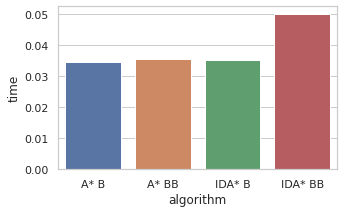

In [91]:
graph(1, "time")

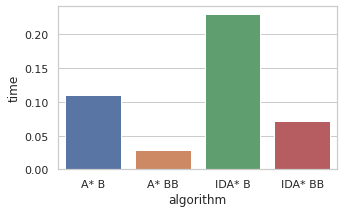

In [92]:
graph(2, "time")

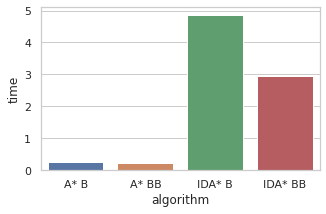

In [93]:
graph(3, "time")

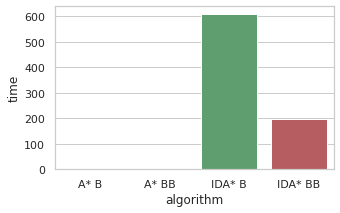

In [94]:
graph(4, "time")

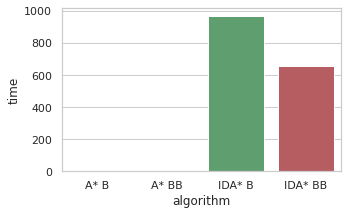

In [95]:
graph(5, "time")

## Nodes Passed

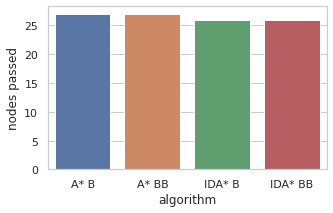

In [79]:
graph(1, "nodes passed")

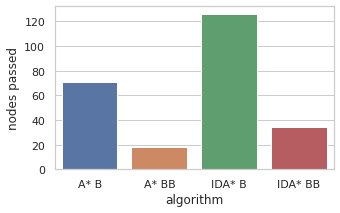

In [80]:
graph(2, "nodes passed")

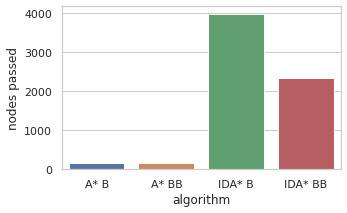

In [81]:
graph(3, "nodes passed")

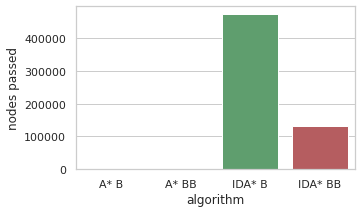

In [82]:
graph(4, "nodes passed")

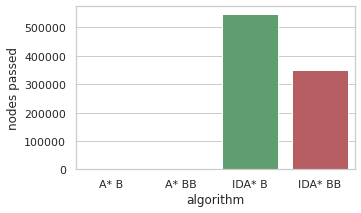

In [83]:
graph(5, "nodes passed")

## Nodes Generated

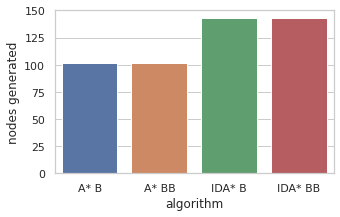

In [84]:
graph(1, "nodes generated")

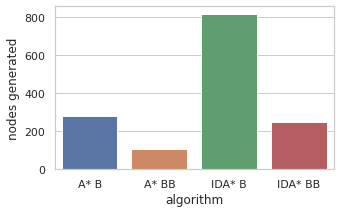

In [85]:
graph(2, "nodes generated")

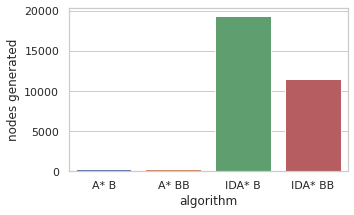

In [86]:
graph(3, "nodes generated")

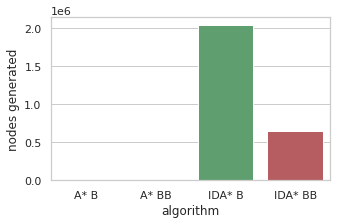

In [87]:
graph(4, "nodes generated")

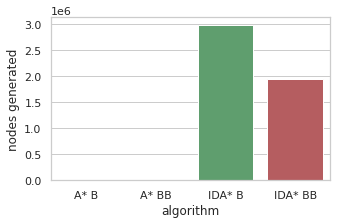

In [88]:
graph(5, "nodes generated")

## Duplicates

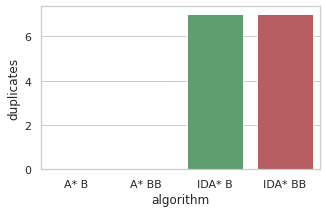

In [90]:
graph(1, "duplicates")

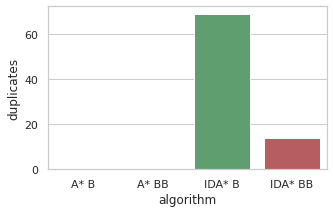

In [96]:
graph(2, "duplicates")

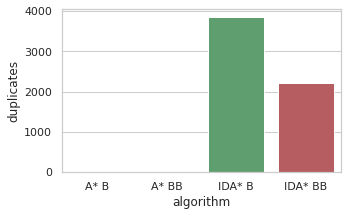

In [97]:
graph(3, "duplicates")

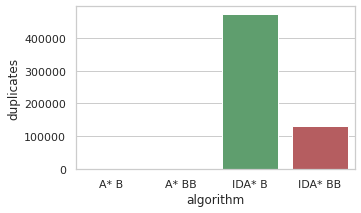

In [98]:
graph(4, "duplicates")

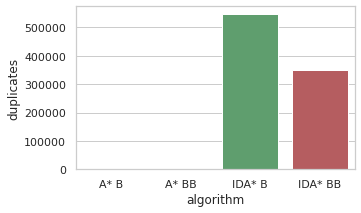

In [99]:
graph(5, "duplicates")